# MILESTONE 2

`File name:` milestone2.py

`Authors:`
- Víctor González
- Alvaro Bautista 
- Alicia Soria 
- Kamil Czerniak

`Date created:` 05/11/2021

`Date last modified:` 12/11/2021

`Python Version:` 3.9.2


---

## Table of contents

**1. INTRODUCTION**
   * Context
   * Project idea
   * Project goals
   * Motivation
   * Feasibility
   
   
   
**2. THE DATA**
   * Quotebank
   * External data
    
    
    
**3. PIPELINE**
   * Load data
   * Examine our data
   * Clean up data
   * Modeling
   * Interpreting
   * Storytelling and communication
    
    
    
**4. CONCLUSIONS**
   * Summary
   * Results
   * Problems encountered
    
    
    
**5. FUTURE LINES**

---

# 1. Introduction

### 1.1. Context

# Brief introduction
Welcome Milestone 2 Python notebook.
In this notebook we will answer several research questions surrounding the Breixit event.
We will employ the Quotebank dataset mainly, as well as additional databases to enrich the data and obtain more
complete conclusions.

### 1.2. Project idea


# Explain in clear, reasonable, and thorough way the project idea
Pinpoint and determine the arguments for and against Breixit in different social groups

### 1.3. Project goals

# Clear project goals

### 1.4. Motivation


In [1]:
# What story do we want to tell, why?
# Critical awareness of the project (social, cultural, political, economic, education. ... impact)

### 1.5. Feasibility

In [2]:
# Justify feasibility given the data

---

# 2. The data

## 2.1. Quotebank

This data source is described best by its makers:

>Quotebank is a dataset of 178 million unique, speaker-attributed quotations that were extracted from 196 million English news articles crawled from over 377 thousand web domains between August 2008 and April 2020. The quotations were extracted and attributed using Quobert, a distantly and minimally supervised end-to-end, language-agnostic framework for quotation attribution.

(*Vaucher, Timoté, Spitz, Andreas, Catasta, Michele, & West, Robert. (2021). Quotebank: A Corpus of Quotations from a Decade of News (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4277311 (accessible on November 10, 2021)*)

In our case, we will use data collected between January 2015 and April 2020. We decided to put the start date in 2015, as this was the year of General Election in the United Kingdom, where the Conservative Party (which won the majority in the House of Commons) has put a promise of an in-out referendum in its manifesto:

>We will negotiate new rules with the EU, so that people will have to be earning here for a number of years before they can claim benefits, including the tax credits that top up low wages. Instead of something-fornothing, we will build a system based on the principle of something-for-something. We will then put these changes to the British people in a straight in-out referendum on our membership of the European Union by the end of 2017.

(*The Conservative Party Manifesto 2015, http://ucrel.lancs.ac.uk/wmatrix/ukmanifestos2015/localpdf/Conservatives.pdf (accessible on November 10, 2021)*)

The data source is based on this paper: Timoté Vaucher, Andreas Spitz, Michele Catasta, and Robert West

"Quotebank: A Corpus of Quotations from a Decade of News"

Proceedings of the 14th International ACM Conference on Web Search and Data Mining (WSDM), 2021.

*https://doi.org/10.1145/3437963.3441760*

## Description of the data
- `quoteID:` Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
- `quotation:` Text of the longest encountered original form of the quotation
- `date:` Earliest occurrence date of any version of the quotation
- `phase:` Corresponding phase of the data in which the quotation first occurred (A-E)
- `probas:` Array representing the probabilities of each speaker having uttered the quotation. The probabilities across different occurrences of the same quotation are summed for each distinct candidate speaker and then normalized
 - `proba:` Probability for a given speaker
 - `speaker:` Most frequent surface form for a given speaker in the articles where the quotation occurred
- `speaker:` Selected most likely speaker. This matches the the first speaker entry in `probas`
- `qids:` Wikidata IDs of all aliases that match the selected speaker
- `numOccurrences:` Number of time this quotation occurs in the articles
- `urls:` List of links to the original articles containing the quotation 

### 2.2. External data

In order to get more context behind the speakers, we opted to use Wikidata dataset. This dataset, meant primarily for use in Wikimedia projects like Wikipedia or Wiktionary, contains properties and references describing an item, e.g., a person or a country. Because Quotebank uses Wikidata QIDs to refer to speakers, we can easily link persons to their attributes in Wikidata. 

Wikidata entries can contain an infinite number of attributes and references, so we have decided to use only a small number of attributes, which we can then use for demographic analysis. These attributes are:
- gender
- date of birth
- nationality
- occupation
- political party
- academic degree
- what political offices a person candidated for
- religion

All of these attributes are capable of containing multiple values (e.g., the entry for Angela Merkel marks her nationality as German and East German). 

This dataset, in its entirety, may have a size of about 100 GB, which is why we decided to use a subset provided by the course (named *speaker_attributes.parquet*). This subset contains these attributes (and a couple more that we opted not to use) for all speakers featured in Quotebank. In addition, we were provided with labels of all Wikidata entries used in the mentioned subset (*wikidata_labels_descriptions_quotebank.csv.bz2*), in order to dereference non-speaker attributes (like gender) more easily. 

#### References
- Wikidata website: https://www.wikidata.org/wiki/Wikidata:Main_Page
- Google Drive directory with preprocessed Wikidata dataset: https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0

---

# 3. Pipeline

# Pipeline we are going to follow
- Load data
- Examine our data
- Clean up data
- Exploring and visualizing
- Modeling
- Interpreting our data
- Storytelling and communication

In [3]:
#Import packages
import re, json, bz2
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
%matplotlib inline
import re, string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
sw = stopwords.words('english')
print('Finished imports')

Finished imports


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorgonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/victorgonzalez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
YEARS = ["2015", "2016", "2017", "2018", "2019", "2020"]

## 3.1. Load data

We encourage you to use Google Colab for executing this part of notebook - Google Colab has support for Google Drive, which in turn has support for linking to external folders, allowing us to use larger datasets without losing space capacity on our accounts. In addition, step 3 relies on loading speaker attributes to memory before handling them - this requires ~6 GB of RAM, which could be an issue on computers with 8 GB of RAM or less.

Each step will generate its own output files, for each year, to limit the strain on following steps and allow analysis of what was removed in each step by comparing pre-step data.

We start by importing libraries that will be used in the pipeline. We also define years to be considered - this will be used to load files for each year and save the output.

In [5]:
# # Step 1: only keep quotes that contain phrases: Brexit OR ((leaving OR leave OR exiting OR exit) AND (EU or European Union))

# regex_text = "(brexit)|((leave|leaving|exit|exiting).*(\W+eu\W+|\W+european union))"
# regex = re.compile(regex_text, re.IGNORECASE)

# for year in YEARS:
#     path_to_file = f'data/quotes-{year}.json.bz2' 
#     path_to_out = f'data/quotes-{year}-step1.json.bz2'

#     with bz2.open(path_to_file, 'rb') as s_file:
#         with bz2.open(path_to_out, 'wb') as d_file:
#             for instance in s_file:
#                 instance = json.loads(instance) # loading a sample
#                 quotation = instance['quotation'] + " " # extracting quotation, space needed to match EU at the end of a sentence
#                 if(regex.match(quotation) is not None):
#                     d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in a new file

The second step removes quotes for which Quobert has not been able to attribute a speaker. Since the part of this project is to figure out who was for or against leaving the European Union, these quotes would not be useful to our analysis. This step should take significantly less time than the previous one - less than a minute.

**Input:** Compressed JSON file with quotes mentioning Brexit from Quotebank from given year, e.g., `quotes-{year}-step1.json.bz2`

**Output:** Compressed JSON file with quotes mentioning Brexit and with a known speaker from Quotebank from given year, e.g., `quotes-{year}-step2.json.bz2`

In [6]:
# # Step 2: only keep quotes that have an attributed speaker
# for year in YEARS:
#     path_to_file = f'data/quotes-{year}-step1.json.bz2' 
#     path_to_out = f'data/quotes-{year}-step2.json.bz2'

#     with bz2.open(path_to_file, 'rb') as s_file:
#         with bz2.open(path_to_out, 'wb') as d_file:
#             for instance in s_file:
#                 instance = json.loads(instance)
#                 speaker = instance['speaker'] # Get the speaker's label
#                 if(speaker != "None"):
#                     d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing to the new file

In [7]:
df_2015_step1 = pd.read_json('./data/quotes-2015-step1.json.bz2', compression='bz2', lines=True)
df_2016_step1 = pd.read_json('./data/quotes-2016-step1.json.bz2', compression='bz2', lines=True)
df_2017_step1 = pd.read_json('./data/quotes-2017-step1.json.bz2', compression='bz2', lines=True)
df_2018_step1 = pd.read_json('./data/quotes-2018-step1.json.bz2', compression='bz2', lines=True)
df_2019_step1 = pd.read_json('./data/quotes-2019-step1.json.bz2', compression='bz2', lines=True)
df_2020_step1 = pd.read_json('./data/quotes-2020-step1.json.bz2', compression='bz2', lines=True)
df_speaker_attributes = pd.read_parquet('./data/speaker_attributes.parquet')

In [8]:
df_2015_step1['year'] = 2015
df_2016_step1['year'] = 2016
df_2017_step1['year'] = 2017
df_2018_step1['year'] = 2018
df_2019_step1['year'] = 2019
df_2020_step1['year'] = 2020
df_step2 = df_2015_step1.append(df_2016_step1, ignore_index=True)
df_step2 = df_step2.append(df_2017_step1, ignore_index=True)
df_step2 = df_step2.append(df_2018_step1, ignore_index=True)
df_step2 = df_step2.append(df_2019_step1, ignore_index=True)
df_step2 = df_step2.append(df_2020_step1, ignore_index=True)

## 3.2. Examine our data

# Understanding what is in data. Get acquainted with the data.
- Formats
- Distributions
- Missing values
- Correlations

#### Understanding what is in data. Cleaning:

- Formats, shapes and data types
- Reading samples of quotes
- Duplicate values
    - Drop duplicates
- Missing values
    - In Quotebank
    - In Speakers_attributes
    - Remove empty quotes (quotebank)
    - Fill empty aliases with labels (speakers_attributes)
- Inconsistent and incorrect values
    - Find more than one qid for each speaker (indicate uncertainity)
    - Find more than one probas for each speaker (indicate uncertainity)
    - Get only first qid for each speaker
    - Missing speakers are associated with their second value in probas if > X% prob
    - Add qid for the associated ones (use speakers_attributes.parquet)
    - Drop rows without found id
    - Ensure same speaker is addressed by the same name

- NLP cleaning
    - Remove unused columns
    - Remove capital letters, punctuations, emojis, links
    - Lemmatization
    - Remove quotes not mentioning Breixit

- Extracting summary statistics & distributions 

#### References:

- NLP and Opinion Mining in Python. Sentiment Analysis of the Rayshard Brooks Shooting (François St-Amant, Jun 2020)

In [9]:
# Formats, shapes and data types
print('\033[1m','Formats, shapes and data types in Quotebank: \n')
print('\033[0m')
df_step2.info()


 Formats, shapes and data types in Quotebank: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7124 entries, 0 to 7123
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   quoteID         7124 non-null   object        
 1   quotation       7124 non-null   object        
 2   speaker         7124 non-null   object        
 3   qids            7124 non-null   object        
 4   date            7124 non-null   datetime64[ns]
 5   numOccurrences  7124 non-null   int64         
 6   probas          7124 non-null   object        
 7   urls            7124 non-null   object        
 8   phase           7124 non-null   object        
 9   year            7124 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 556.7+ KB


In [10]:
# Formats, shapes and data types
print('\033[1m','Formats, shapes and data types in speakers_attributes: \n')
print('\033[0m')
df_speaker_attributes.info()

 Formats, shapes and data types in speakers_attributes: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055981 entries, 0 to 9055980
Data columns (total 15 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   aliases             object
 1   date_of_birth       object
 2   nationality         object
 3   gender              object
 4   lastrevid           int64 
 5   ethnic_group        object
 6   US_congress_bio_ID  object
 7   occupation          object
 8   party               object
 9   academic_degree     object
 10  id                  object
 11  label               object
 12  candidacy           object
 13  type                object
 14  religion            object
dtypes: int64(1), object(14)
memory usage: 1.0+ GB


In [11]:
# Reading samples of quotes
print('\033[1m','Reading a sample of quotes: \n')
df_step2.head(1)

 Reading a sample of quotes: 



,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year
0,2015-05-20-006834,Brexit is a big risk because we are more depen...,None,[],2015-05-20 20:17:06,2,"[[None, 0.8754], [George Osborne, 0.1246]]",[http://cnbc.com/id/102687026?trknav=homestack...,E,2015


 Duplicate values of  7124  total elements 

 Duplicated  quoteID :  0 
 Duplicated  quotation :  0 
 Duplicated  speaker :  4892 
 Duplicated  date :  459 
 Duplicated  numOccurrences :  6963 
 Duplicated  phase :  7123 
 Duplicated  year :  7118 


/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


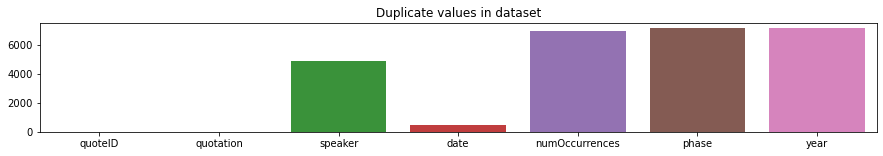

In [12]:
# Duplicate values
print('\033[1m','Duplicate values of ',len(df_step2),' total elements \n')

c=list(df_step2.columns)
c.remove('qids')
c.remove('probas')
c.remove('urls')
v = []

for m in c:
    print('\033[0m','Duplicated ',m,': ',df_step2.duplicated([m]).sum(),'')
    v.append(df_step2.duplicated([m]).sum())
fig, axs = plt.subplots(1, 1,figsize=(15,2))
sns.barplot(c,v)
axs.set_title('Duplicate values in dataset')
plt.show()

In [13]:
# Drop duplicates
print('\033[1m', 'There are no duplicate quotations or quoteIDs\n') 

 There are no duplicate quotations or quoteIDs



 Missing values of  7124  total elements 

 Missing  quoteIDs :  0 
 Missing  quotation :  0 
 Missing  speaker :  2439 
 Missing  qids :  2439 
 Missing  numOcurr :  0 
 Missing  probas :  0 


/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


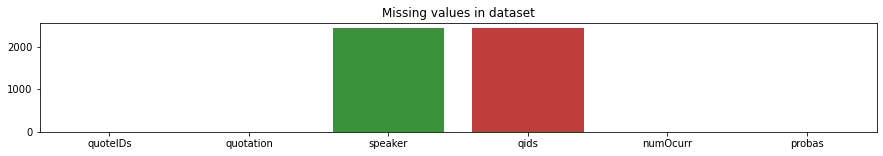

In [14]:
# Missing values for quotebank
print('\033[1m','Missing values of ',len(df_step2),' total elements \n')

mqid = len(df_step2) -len(df_step2[df_step2["quoteID"].notnull()])
mq = len(df_step2) -len(df_step2[df_step2["quotation"].notna()])
ms = len(df_step2[df_step2["speaker"] == 'None'])
mqiss = len(df_step2[(df_step2.qids.apply(lambda x: len(x)==0))])
mno = len(df_step2[df_step2["numOccurrences"] == 0])
mp = len(df_step2[(df_step2.probas.apply(lambda x: len(x)==0))])

missing = ['quoteIDs','quotation','speaker','qids','numOcurr','probas']
vals = [mqid,mq,ms,mqiss,mno,mp]
for i in range(len(vals)):
    print('\033[0m','Missing ',missing[i],': ',vals[i],'')
    
fig, axs = plt.subplots(1, 1,figsize=(15,2))
sns.barplot(missing,vals)
axs.set_title('Missing values in dataset')
plt.show()

In [15]:
# Remove empty quotes
print('\033[1m', 'There are no emtpy rows or missing quotations')

 There are no emtpy rows or missing quotations


 Missing values of  9055981  total elements 

 Missing  aliases :  7852579 
 Missing  date_of_birth :  4038648 
 Missing  nationality :  5340129 
 Missing  gender :  1950381 
 Missing  lastrevid :  0 
 Missing  ethnic_group :  8925596 
 Missing  US_congress_bio_ID :  9043107 
 Missing  occupation :  2682897 
 Missing  party :  8656805 
 Missing  academic_degree :  8955986 
 Missing  id :  0 
 Missing  label :  512300 
 Missing  candidacy :  8990539 
 Missing  religion :  8859697 


/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


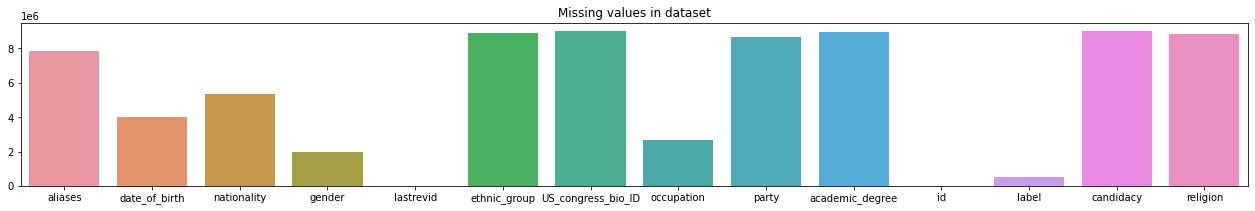

In [16]:
# Missing values for speakers_attributes
print('\033[1m','Missing values of ',len(df_speaker_attributes),' total elements \n')

vals = []
missing = ['aliases','date_of_birth','nationality','gender','lastrevid','ethnic_group','US_congress_bio_ID','occupation','party','academic_degree','id','label','candidacy','religion']
for m in missing:
    vals.append(len(df_speaker_attributes[df_speaker_attributes[m].isnull()]))
for i in range(len(vals)):
    print('\033[0m','Missing ',missing[i],': ',vals[i],'')

fig,axs = plt.subplots(1, 1,figsize=(22,3))
sns.barplot(missing,vals)
axs.set_title('Missing values in dataset')
plt.show()

/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


 Incorrect or inconsistent values: 

 More than 1 qids or probas: Indicates uncertainity in the identity of the speaker
 1  qids:  3281 ;  1  probas 0 
 2  qids:  613 ;  2  probas 3438 
 3  qids:  201 ;  3  probas 1917 
 4  qids:  118 ;  4  probas 910 
 5  qids:  86 ;  5  probas 380 
 6  qids:  54 ;  6  probas 208 
 7  qids:  64 ;  7  probas 101 


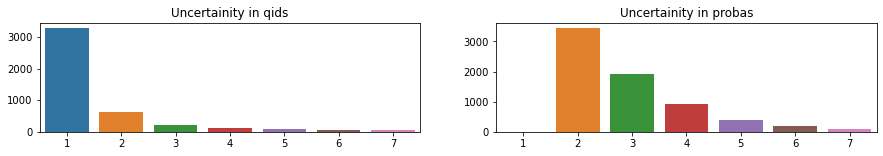

In [17]:
# Incorrect or inconsistent values.
# Find more than one qid or probas for each speaker (indicate uncertainity)
print('\033[1m','Incorrect or inconsistent values: \n')
print('\033[0m','More than 1 qids or probas: Indicates uncertainity in the identity of the speaker')

uncertainity = [1,2,3,4,5,6,7]
qids_uncert=[]
p_uncert = []
for d in uncertainity:
    u = len(df_step2[(df_step2.qids.apply(lambda x: len(x)==d))])
    qids_uncert.append(u)
    p = len(df_step2[(df_step2.probas.apply(lambda x: len(x)==d))])
    p_uncert.append(p)
    print('\033[0m',d,' qids: ',u,'; ',d,' probas',p,'')
fig, axs = plt.subplots(1, 2,figsize=(15,2))
sns.barplot(uncertainity,qids_uncert,ax=axs[0])
axs[0].set_title('Uncertainity in qids')
sns.barplot(uncertainity,p_uncert,ax=axs[1])
axs[1].set_title('Uncertainity in probas')
plt.show()

In [18]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # # print list
    # for x in unique_list:
    #     print x
    return unique_list

In [19]:
# Get only the first qid for each speaker
print('\033[1m','We keep only the first qid for each speaker and check that Speaker-Qids are consistent \n')
print('\033[1m', 'Chose only the first qid for each speaker \n') 
df_step2['unique_qids'] = df_step2.qids.apply(lambda y: [] if len(y)==0 else [y[0]]) # Find unique qids
print('\033[0m','It is possible to have different names for the same speaker ex: President Trump, Donald Trump \n')
print('\033[0m','There are: ', df_step2.speaker.nunique(), ' unique speakers \n There are: ',len(unique(df_step2.unique_qids)),' unique qids')
print(' Therefore different names correspond to the same qid, as there are the same amount of missing values for both.\n')

 We keep only the first qid for each speaker and check that Speaker-Qids are consistent 

 Chose only the first qid for each speaker 

 It is possible to have different names for the same speaker ex: President Trump, Donald Trump 

 There are:  2232  unique speakers 
 There are:  2187  unique qids
 Therefore different names correspond to the same qid, as there are the same amount of missing values for both.



In [20]:
# Missing speakers are associated their second value in 'probas' if >X%
print('\033[1m', 'Associate missing speakers with their second value in \'probas\' column if >X% \n') 

i = list(df_step2[df_step2.speaker=='None'].index) # First find the empty speakers
empty = df_step2.iloc[i]
indexes = [x for x in empty.index if float(empty.loc[x,'probas'][1][1])>0.4] # Where prob > X%
subs = [x[1][0] for x in df_step2.loc[indexes,'probas']] # get the second speaker after 'None'
b = zip(indexes,subs)
dn = pd.DataFrame(b)
xn = dn.set_index(0)
df_step2.loc[indexes,'speaker']= xn.loc[indexes,1] # Substitute the empty speaker for the second option
df_step2 = df_step2[df_step2.speaker!='None'] # Drop those that still are not filled

 Associate missing speakers with their second value in 'probas' column if >X% 



In [21]:
# Inconsistent and incorrect values. Some aliases are empty so they are filled with the 'label' value
print('\033[1m','Fill empty aliases with \'label\' value \n')
inull = df_speaker_attributes[df_speaker_attributes.aliases.isnull()].index
df_speaker_attributes.loc[inull,'aliases'] = df_speaker_attributes.loc[inull,'label']
df_speaker_attributes = df_speaker_attributes.dropna(subset=['aliases'])

 Fill empty aliases with 'label' value 



In [22]:
names_wo_id = list(df_step2[df_step2.unique_qids.apply(lambda x: len(x) ==0)]['speaker'])
names_wo_id_df = pd.DataFrame(names_wo_id).drop_duplicates()
names_wo_id = list(names_wo_id_df[0])

In [23]:
# Add qid for the ones that were missing (use speakers_attributes.parquet)
print('\033[1m','Find the qids that correspond to each speaker from the speakers_attributes file \n')
kv = []
for query in names_wo_id:
    idss=list(df_speaker_attributes[df_speaker_attributes.aliases.apply(lambda y: query in y)].id)
    theid = [idss[0]] if len(idss)>0 else None
    kv.append({'name':query,'qid':theid})
auxi = pd.DataFrame(kv)
auxi = auxi.dropna(subset=['qid'])

 Find the qids that correspond to each speaker from the speakers_attributes file 



In [24]:
print('\033[0m','We set the indices of df_step2 and auxiliar df to speakers in order to assign qids')
auxi = auxi.set_index('name')
auxi.head(5)
keepindex = df_step2.index # store the index for later
df_step2 = df_step2.set_index('speaker') # change the index to the 'speakers'

print('\033[0m','Finally we substitute the None qids with valid qids \n')
df_step2.loc[auxi.index,'unique_qids'] = auxi.loc[auxi.index,'qid']
df_step2['speaker'] = df_step2.index # rescue the speakers' column
df_step2 = df_step2.set_index(keepindex) # rescue the previous index

 We set the indices of df_step2 and auxiliar df to speakers in order to assign qids
 Finally we substitute the None qids with valid qids 



In [25]:
# Drop rows without found qid
print('\033[1m','Remove rows without found qid: \n ')
df_step2.unique_qids = df_step2.unique_qids.apply(lambda y: np.nan if len(y)==0 else y)

 Remove rows without found qid: 
 


In [26]:
df_step2=df_step2.dropna(0,subset=['unique_qids'])
df_step2['qids'] = df_step2['unique_qids']
df_step2 = df_step2[["quoteID", "quotation", "speaker", "qids", "date", "numOccurrences", "probas", "urls", "phase", "unique_qids", "year"]]
df_step2 = df_step2.drop('unique_qids', axis=1)
df_step2 = df_step2.dropna(subset=['qids'])


/var/folders/cz/drxl2w614qg049wmqrzy06ww0000gn/T/ipykernel_59671/3429386439.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df_step2=df_step2.dropna(0,subset=['unique_qids'])


In [27]:
df_step2.to_json(path_or_buf='./data/df_step2.json.bz2', orient='records', compression='bz2', lines=True)

The third and final step involves matching each quote with attributes of its speaker. As mentioned above, this is done by looking into Wikidata subset datasource and grabbing attributes assigned to most likely speaker's Wikidata QID. Because some fields may be empty (due to missing data), we make sure that this case is handled correctly.

**Inputs:**
- compressed JSON file with quotes mentioning Brexit and with a known speaker from Quotebank `df_step2.json.bz2`

- Wikidata subset with data regarding speakers from Quotebank, stored as a .parquet file, i.e. `speaker_attributes.parquet`

- Wikidata subset with labels and descriptions of all references mentioned in .parquet Wikidata subset, i.e. `wikidata_labels_descriptions_quotebank.csv.bz2`

**Output:** Compressed JSON file with quotes mentioning Brexit and with a known speaker from Quotebank from all years, alongside attributes for speaker of each quote: `df_step3.json.bz2`

**NOTE:** Wikidata `.parquet` file is stored in memory, which could take ~6 GB of your RAM - please consider using Google Colab, which by default provides 12 GB of RAM.

In [28]:
# # Step 3: merge data from Quotebank and Wikidata
# # NOTE: Wikidata parquet requires ~7 GB of RAM available - please use Colab for this step
# wd_df = pd.read_parquet('./data/speaker_attributes.parquet')
# wd_df.set_index('id', inplace=True)

# wd_desc_df = pd.read_csv('./data/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

# path_to_file = f'./data/df_step2.json.bz2'
# path_to_out = f'./data/df_step3.json.bz2'
# index_of_wd_df = set(wd_df.index)
# with bz2.open(path_to_file, 'rb') as s_file:
#     with bz2.open(path_to_out, 'wb') as d_file:
#         for instance in s_file:
#             instance = json.loads(instance) # loading a sample
#             qid = list(index_of_wd_df.intersection(set(instance['qids'])))
#             if(len(qid) == 0):
#                 # Overall, two quotes get ignored due to no match in Wikidata
#                 d_file.write((json.dumps(instance)+'\n').encode('utf-8')) 
#                 continue
#             if (wd_df['gender'][qid][0] is not None):
#               instance['gender'] = wd_desc_df['Label'][wd_df['gender'][qid][0]].tolist()
#             else:
#               instance['gender'] = []
#             if (wd_df['date_of_birth'][qid][0] is not None):
#               instance['date_of_birth'] = wd_df['date_of_birth'][qid][0].tolist()
#             else:
#               instance['date_of_birth'] = []
#             if (wd_df['nationality'][qid][0] is not None):
#               instance['nationality'] = wd_desc_df['Label'][wd_df['nationality'][qid][0]].tolist()
#             else:
#               instance['nationality'] = []
#             if (wd_df['occupation'][qid][0] is not None):
#               instance['occupation'] = wd_desc_df['Label'][wd_df['occupation'][qid][0]].tolist()
#             else:
#               instance['occupation'] = []
#             if (wd_df['party'][qid][0] is not None):
#               instance['party'] = wd_desc_df['Label'][wd_df['party'][qid][0]].tolist()
#             else:
#               instance['party'] = []
#             if (wd_df['academic_degree'][qid][0] is not None):
#               instance['academic_degree'] = wd_desc_df['Label'][wd_df['academic_degree'][qid][0]].tolist()
#             else:
#               instance['academic_degree'] = []
#             if (wd_df['candidacy'][qid][0] is not None):
#               instance['candidacy'] = wd_desc_df['Label'][wd_df['candidacy'][qid][0]].tolist()
#             else:
#               instance['candidacy'] = []
#             if (wd_df['religion'][qid][0] is not None):
#               instance['religion'] = wd_desc_df['Label'][wd_df['religion'][qid][0]].tolist()
#             else:
#               instance['religion'] = []
#             d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file


In [29]:
df_step3 = pd.read_json('./data/df_step3.json.bz2', compression='bz2', lines=True)


# Justify feasibility given the data
- Format is appropriate for analysis
- Enough quotes
- Quotes addressing the issue
- Different speakers involved
- Uniformity of speakers (not all from the same speaker)
- Long and short sentences
- Not many missing quotes
- Not many missing speakers
- There shouldnt be many correlations between (i dont know)

## 3.3. Clean up data

# Generic cleaning
- Identify duplicates
- Remove empty quotes
- Remove empty speakers

#### PARQUET FILE


In [30]:
# Formats, shapes and data types
print('\033[1m','Formats, shapes and data types: \n')
print('\033[0m')
df_speaker_attributes.info()

 Formats, shapes and data types: 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8544170 entries, 0 to 9055980
Data columns (total 15 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   aliases             object
 1   date_of_birth       object
 2   nationality         object
 3   gender              object
 4   lastrevid           int64 
 5   ethnic_group        object
 6   US_congress_bio_ID  object
 7   occupation          object
 8   party               object
 9   academic_degree     object
 10  id                  object
 11  label               object
 12  candidacy           object
 13  type                object
 14  religion            object
dtypes: int64(1), object(14)
memory usage: 1.0+ GB


In [31]:
# Reading samples of quotes
print('\033[1m','Reading a sample of speakers_attributes: \n')
df_speaker_attributes.head(2)

 Reading a sample of speakers_attributes: 



,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None


In [32]:
# Duplicate values
print('\033[0m','Duplicated ids: ',df_speaker_attributes.duplicated(['id']).sum(),'')
print('\033[0m','Duplicated label: ',df_speaker_attributes.duplicated(['label']).sum(),'') #could be 'none'

 Duplicated ids:  0 
 Duplicated label:  1256871 


 Missing values of  8544170  total elements 

 Missing  aliases :  0 
 Missing  date_of_birth :  3877231 
 Missing  nationality :  5015154 
 Missing  gender :  1831888 
 Missing  lastrevid :  0 
 Missing  ethnic_group :  8425362 
 Missing  US_congress_bio_ID :  8531296 
 Missing  occupation :  2470043 
 Missing  party :  8183245 
 Missing  academic_degree :  8471896 
 Missing  id :  0 
 Missing  label :  489 
 Missing  candidacy :  8479585 
 Missing  religion :  8361006 


/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


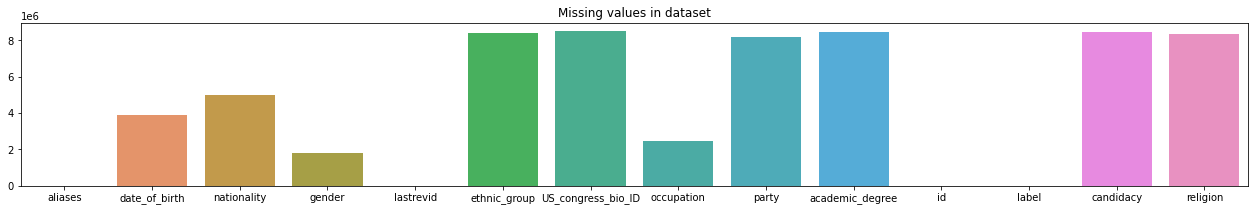

In [33]:
# Missing values
print('\033[1m','Missing values of ',len(df_speaker_attributes),' total elements \n')

vals = []
missing = ['aliases','date_of_birth','nationality','gender','lastrevid','ethnic_group','US_congress_bio_ID','occupation','party','academic_degree','id','label','candidacy','religion']
for m in missing:
    vals.append(len(df_speaker_attributes[df_speaker_attributes[m].isnull()]))
for i in range(len(vals)):
    print('\033[0m','Missing ',missing[i],': ',vals[i],'')

fig,axs = plt.subplots(1, 1,figsize=(22,3))
sns.barplot(missing,vals)
axs.set_title('Missing values in dataset')
plt.show()

In [34]:
# Inconsistent and incorrect values. Some aliases are empty so they are filled with the 'label' value
print('\033[1m','Fill empty aliases with \'label\' value \n')

inull = df_speaker_attributes[df_speaker_attributes.aliases.isnull()].index
df_speaker_attributes.loc[inull,'aliases'] = df_speaker_attributes.loc[inull,'label']
df_speaker_attributes = df_speaker_attributes.dropna(subset=['aliases'])
df_speaker_attributes.tail(3)


 Fill empty aliases with 'label' value 



,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
9055978,Dina David,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,Irma Dexinger,[+1899-03-18T00:00:00Z],None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None
9055980,[Fred Trull],None,[Q30],[Q6581097],1397400809,None,None,[Q82955],None,None,Q106406643,Fred F. Trull,None,item,None


The first step removes quotes that are not mentioning Brexit and as such are irrelevant to our analysis. We do this by using a regular expression that matches quotes that either contain the phrase "Brexit" or the combination of "leave", "leaving", "exit", "exiting" and "EU" or "European Union". We use a streaming approach used [here](https://colab.research.google.com/drive/1NqLFrAWAzKxr2dAWHI7m6Ml3gWGF72cA) in order to reduce the strain on RAM usage (each datasource file is approx. 2 GB in size).

**Input:** Compressed JSON file with quotes from Quotebank from given year, e.g., `quotes-{year}.json.bz2`

**Output:** Compressed JSON file with quotes mentioning Brexit from Quotebank from given year, e.g., `quotes-{year}-step1.json.bz2`

**NOTE**: due to large number of quotes, this step can take long time - possibly over an hour. You have been warned.

 Investigate summary distributions


/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/victorgonzalez/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

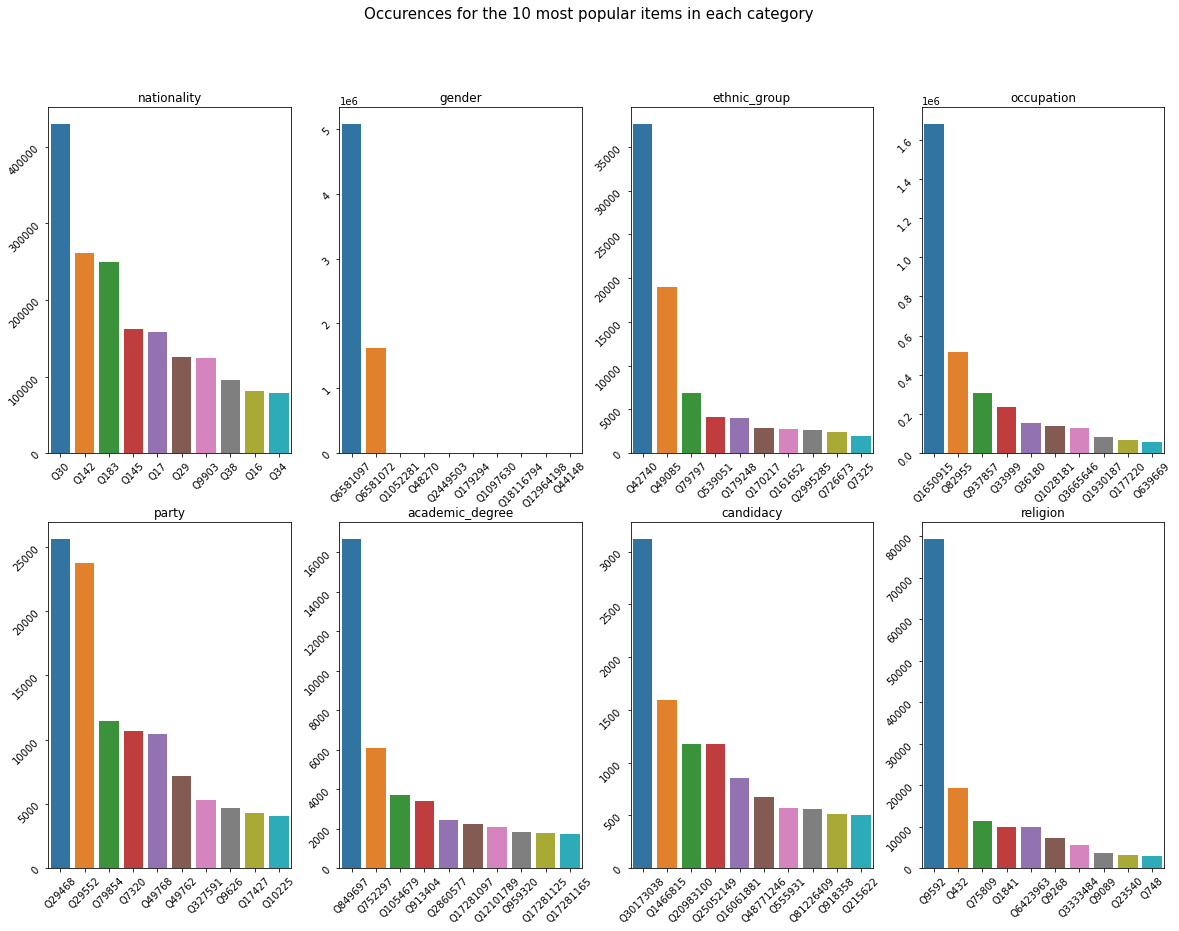

In [35]:
# Extracting summary statistics & distributions 
from collections import Counter
print('\033[1m','Investigate summary distributions')

labs = ['nationality','gender','ethnic_group','occupation','party','academic_degree','candidacy','religion']
fig, axs = plt.subplots(2, 4,figsize=(20,14))

n = 0
for ele in labs:
    f = int(np.floor(n/4))
    c = n%4
    a =[x[0] for x in list(df_speaker_attributes.dropna(subset=[ele])[ele])]
    r = Counter(a)
    b = r.most_common()[0:10]
    k = [i[0] for i in b]
    v = [i[1] for i in b]
    sns.barplot(k,v,ax = axs[f][c])
    axs[f][c].set_title(labs[n])
    axs[f][c].tick_params(labelrotation=45)

    n+=1
plt.suptitle('Occurences for the 10 most popular items in each category',fontsize=15)
plt.show()

# NLP cleaning
- Remove capital letters, punctuations, emojis, links
- Remove quotes not mentioning Breixit

In [36]:
df_quotes = df_step3

In [37]:
# Remove capital letters, punctuations, emojis, links

def clean_text(text):
    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)
    
    #Tokenize the data
    text = nltk.word_tokenize(text)
    #Remove stopwords
    text = [w for w in text if w not in sw]
    return text

df_quotes['quotation'] = df_quotes['quotation'].apply(lambda x: clean_text(x))

In [38]:
# Lemmatization
# The process of grouping together the inflected forms of a word so they can be analyzed as a single item, 
# since they have a similar meaning (walking becomes walk, officers becomes officer, etc.)

lemmatizer = WordNetLemmatizer()
def lem(text):
    text = [lemmatizer.lemmatize(t) for t in text]
    text = [lemmatizer.lemmatize(t, 'v') for t in text]
    return text
df_quotes['quotation'] = df_quotes['quotation'].apply(lambda x: lem(x))
df_quotes=df_quotes.reset_index(drop=True)

## 3.4. Exploring and visualization

### Plan for analysis

# For each of the questions include the following (even though it is not enriched in the end for ex):
- Various choices of analyses that we thought about but discarded 
- Consider ways to enrich, filter, transform data according to needs 
- Final good choice for analysis. Has to be reasonable and sound
- Complete necessary descriptive statistic tasks

# State and describe all of our questions
- Q1: Which percentage of the speakers supported or was against Brexit?
- Q2: What arguments did the members of each category use to support their beliefs? 
- Q3: Who were the main supporters of each of the categories? Analyze them according to age, gender, occupation, ...
- Q4: How did the opinion towards Brexit change during the 5 year span? Did the arguments of each group also change?

## Q1: Which percentage of the speakers supported or was against Brexit?

To answer this question we are going to use Textblob’s sentiment function. This function allows us to look at: 
- the polarity of a quote: by returning a float number that ranges from -1 (the most negative) to 1 (the most positive)
- the subjectivity of a quote: by returning a float number that ranges from 0 (very objective) to 1 (very subjective)

We defined a function `get_sentiment(dataframe)`that gets the polarity and subjectivity for every quote, and then plotted the  distribution of said polarity:


In [39]:
def get_sentiment(dataframe):
    '''
    Create a new column with the sentiment of the quote'
    :param dataframe: pandas.DataFrame
    :return: new dataframe
    '''
    #Get sentiment from comments
    dataframe['quotation_sentiment'] = [str(thing) for thing in dataframe['quotation']]
    polarity = []
    subjectivity = []
    for i in range(len(dataframe)):
        blob = TextBlob(dataframe['quotation_sentiment'].iloc[i])
        for sentence in blob.sentences:
            polarity.append(sentence.sentiment.polarity)
            subjectivity.append(sentence.sentiment.subjectivity)
            
    dataframe['polarity']=polarity
    dataframe['subjectivity']=subjectivity
    return dataframe

Text(0.5, 0, 'Subjectivity score')

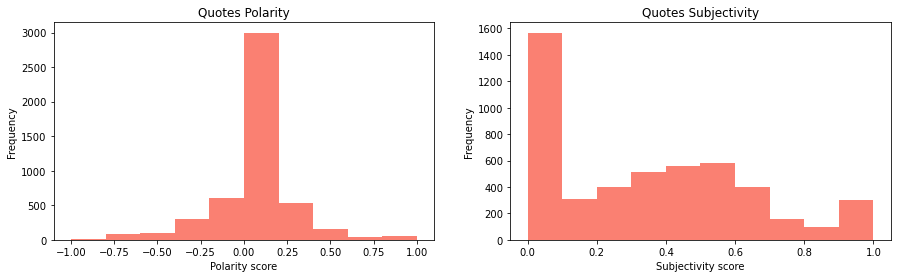

In [40]:
#Get polarity of quotes
df_quotes_with_sentiment = df_quotes
df_quotes_with_sentiment = get_sentiment(df_quotes_with_sentiment)
#Plot
fig, axs = plt.subplots(1, 2,figsize=(15,4))
df_quotes_with_sentiment['polarity'].plot.hist(color='salmon', title='Quotes Polarity', ax=axs[0])
df_quotes_with_sentiment['subjectivity'].plot.hist(color='salmon', title='Quotes Subjectivity', ax=axs[1])
axs[0].set_xlabel('Polarity score')
axs[1].set_xlabel('Subjectivity score')


In [41]:
df_quotes_with_sentiment['polarity'].describe()

count    4874.000000
mean        0.040556
std         0.234116
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.133333
max         1.000000
Name: polarity, dtype: float64

In [42]:
polarized_comments = len(df_quotes_with_sentiment.loc[(df_quotes_with_sentiment['polarity'] < -0.5)|(df_quotes_with_sentiment['polarity'] > 0.5)])
f'Number of extremely polarized comments: {polarized_comments}'

'Number of extremely polarized comments: 234'

---
We use polarity score to classifying positive and negative sentiments in the different quotes. The conclusions we obtain are: 

- The vast majority of quotes are what could be considered as rather neutral, with the mean quote having a polarity of 0.040556. 
- About 75% of the quotes have a polarity of less than 0.133333, meaning there are very few polarized quotes.  
- In fact, only 234 of the 4874 quotes are considered to be very polarized (more than 0.5 or less than -0.5). 

---

If we do a deeper analysis , we can classify the speakers based on the polarity of their quotes. This will alow us to identify the opinion speakers have towards Brexit, and the percentages of supporter or detractors it has. 

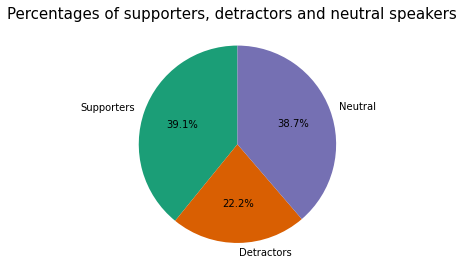

In [43]:
# Classify supporters, detractors and neutral quotes based on the polarity obtained
supporters = df_quotes_with_sentiment.loc[df_quotes_with_sentiment['polarity'] > 0]
supporters_percentage = len(supporters.index)/len(df_quotes_with_sentiment.index)
detractors = df_quotes_with_sentiment.loc[df_quotes_with_sentiment['polarity'] < 0]
detractors_percentage = len(detractors.index)/len(df_quotes_with_sentiment.index)
neutral = df_quotes_with_sentiment.loc[df_quotes_with_sentiment['polarity'] == 0]
neutral_percentage = len(neutral.index)/len(df_quotes_with_sentiment.index)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Supporters', 'Detractors', 'Neutral'
colors = ['#1b9e77', '#d95f02', '#7570b3']
sizes = [supporters_percentage, detractors_percentage, neutral_percentage]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Percentages of supporters, detractors and neutral speakers',fontsize=15)
plt.show()

As a last step, we can focus on the speakers whose nationality is British, so we can make a smarter approach of the problem. 

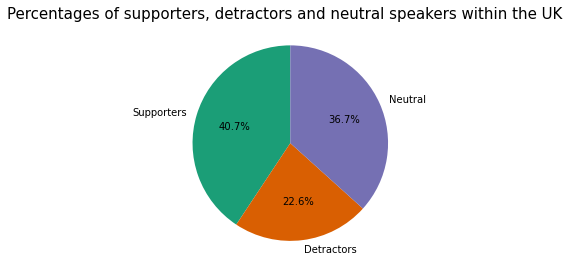

In [44]:
# Classify supporters, detractors and neutral quotes based on the polarity obtained only for British speakers. 
supporters_uk = supporters[supporters['nationality'].apply(lambda x: 'United Kingdom' in str(x))]
detractors_uk = detractors[detractors['nationality'].apply(lambda x: 'United Kingdom' in str(x))]
neutral_uk = neutral[neutral['nationality'].apply(lambda x: x == ['United Kingdom'])]
total = len(supporters_uk.index) + len(detractors_uk.index) +  len(neutral_uk.index)
supporters_uk_percentage = len(supporters_uk.index)/total
detractors_uk_percentage = len(detractors_uk.index)/total
neutral_uk_percentage = len(neutral_uk.index)/total

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Supporters', 'Detractors', 'Neutral'
colors = ['#1b9e77', '#d95f02', '#7570b3']
sizes = [supporters_uk_percentage, detractors_uk_percentage, neutral_uk_percentage]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Percentages of supporters, detractors and neutral speakers within the UK',fontsize=15)
plt.show()

---
If we analyze the two pie charts, we can see that the results are quite close to reality. The percentage of detractors (22.6%) is almost half that of the supporters (40.7%), while there is also a vast majority of neutral people (36.7%). 

However, if we look at the percentages within the UK, the results differ a bit from what we expected. 

It can be seen that the percentages are very similar to the previous ones, with a small increase in supporters and detractors. We consider that this results are not so close to reality, as the atmosphere should be more polarized within the country.

---

#### Q2: What arguments did the members of each category use to support their beliefs? 


To extract the most used arguments by the members of each category we are going to begin by looking at the word frequency of each group, i.e. what words are repeated most often in the quotes of each speakers. To achieve this we are going to use the FreqDist function from nltk. 

This function gives us lists with the most frequent samples, bigrams and trigrams within the quotes. 
To clarify: 
- a bigram is pair of words that are next to each other in a quote
- a trigram is trio of words that are next to each other in a quote

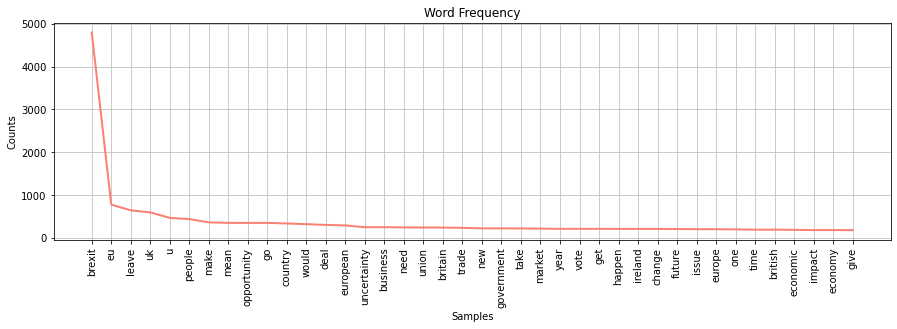

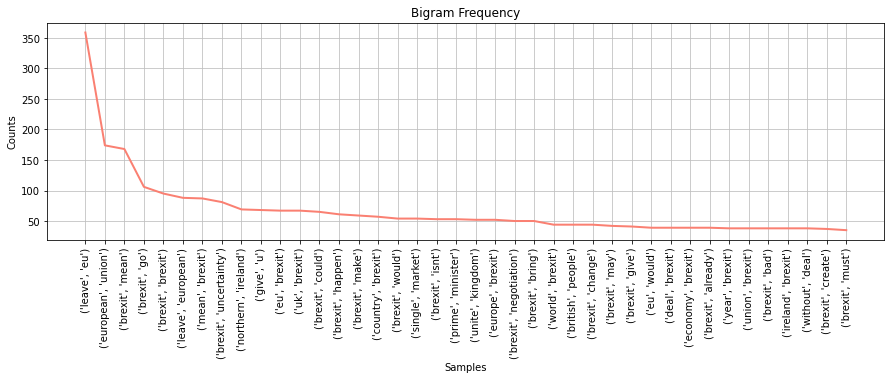

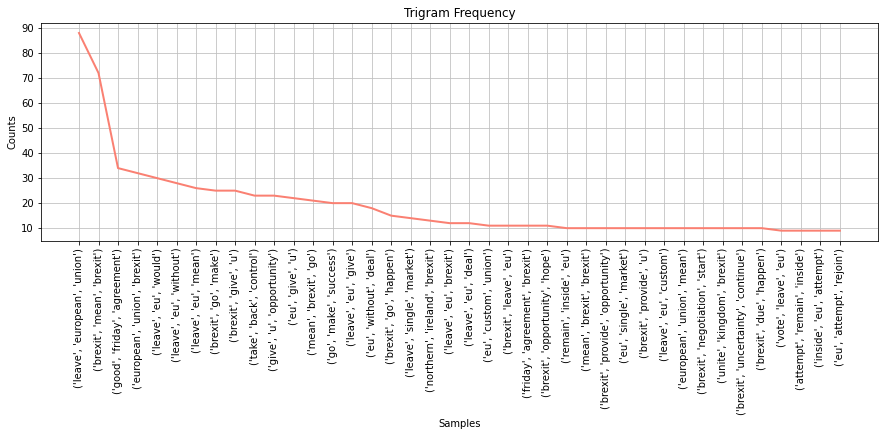

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [45]:
#From lists of quotes to a single list containing all words      
all_words=[]        
for i in range(len(df_quotes)):
    all_words = all_words + df_quotes['quotation'].iloc[i]

#Get word frequency with ntlk
words_1 = nltk.FreqDist(all_words)
plt.figure(figsize=(15,4))

words_1.plot(40, color='salmon', title='Word Frequency')
#Bigrams
bigrm = list(nltk.bigrams(all_words))
words_2 = nltk.FreqDist(bigrm)
plt.figure(figsize=(15,4))

words_2.plot(40, color='salmon', title='Bigram Frequency')
#Trigrams
trigrm = list(nltk.trigrams(all_words))
words_3 = nltk.FreqDist(trigrm)
plt.figure(figsize=(15,4))

words_3.plot(40, color='salmon', title='Trigram Frequency')

---
To no one's surprise, 'Brexit' is the most repeated word with 4797 appearances, followed by 'eu' with 775 and 'leave' with 643. 

If we analyze the bigrams, "leave eu" came up the most with 359 appearances, followed by "european union" with 174 and "brexit mean" with 168. It is necessary to highlight two bigrams that caught our attention: "brexit uncertainty" and "northern ireland". 

Related to the trigrams, "leave european union" appears the most a total of 88 times, followed by "breacit mean brexit" with 72 appearances and "good friday agreement" with 34. 

The previous analysis does not give us much idea about how people abput Brexit overall. 

---

To do an in-depth analysis, we are going to split the words between supporters and detractors, and try to extract conclussions from the arguments followed by each of the different groups. 

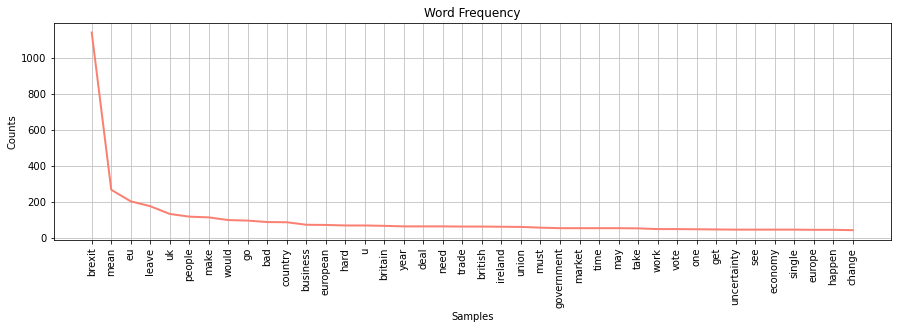

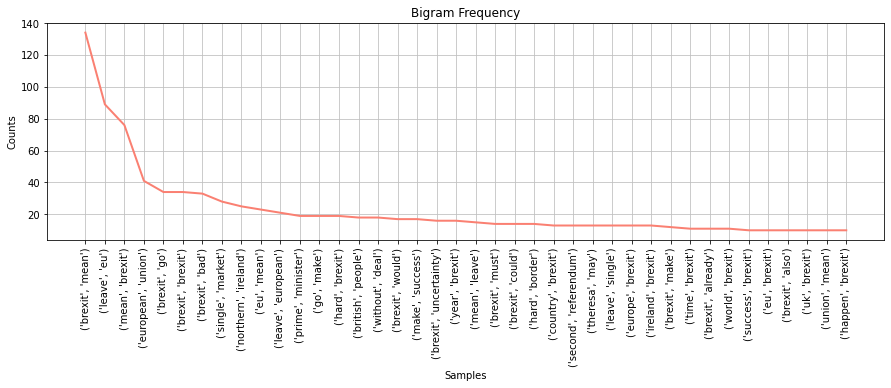

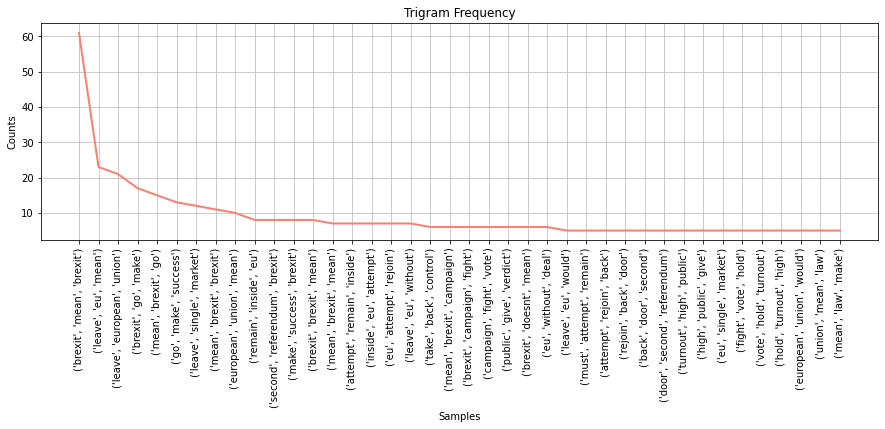

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [46]:
#From lists of detractors quotes to a single list containing all detractors words      
detractors_words=[]        
for i in range(len(detractors)):
    detractors_words = detractors_words + detractors['quotation'].iloc[i]

#Get word frequency        
words_1_detractors = nltk.FreqDist(detractors_words)
plt.figure(figsize=(15,4))

words_1_detractors.plot(40, color='salmon', title='Word Frequency')
#Bigrams
bigrm_detractors = list(nltk.bigrams(detractors_words))
words_2_detractors = nltk.FreqDist(bigrm_detractors)
plt.figure(figsize=(15,4))

words_2_detractors.plot(40, color='salmon', title='Bigram Frequency')
#Trigrams
trigrm_detractors = list(nltk.trigrams(detractors_words))
words_3_detractors = nltk.FreqDist(trigrm_detractors)
plt.figure(figsize=(15,4))

words_3_detractors.plot(40, color='salmon', title='Trigram Frequency')

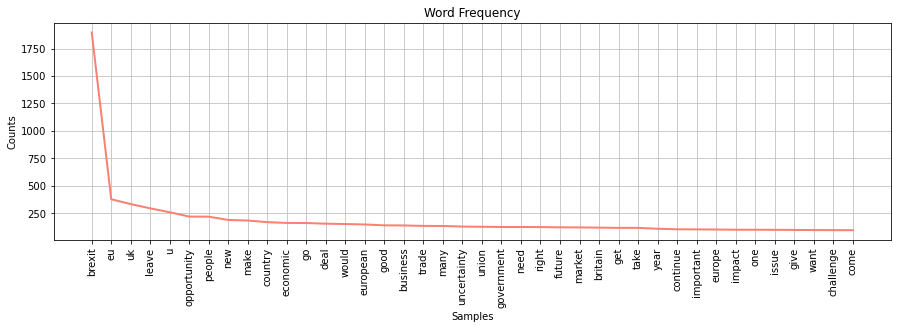

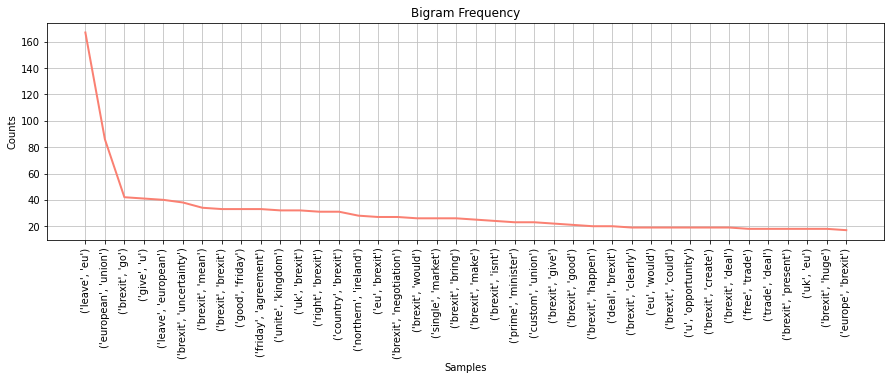

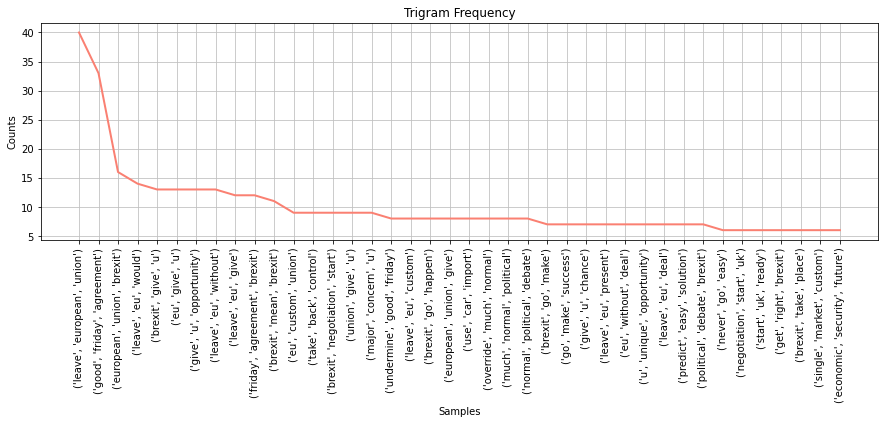

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [47]:
#From lists of supporters quotes to a single list containing all supporters words      
supporters_words=[]        
for i in range(len(supporters)):
    supporters_words = supporters_words + supporters['quotation'].iloc[i]

#Get word frequency        
words_1_supporters = nltk.FreqDist(supporters_words)
plt.figure(figsize=(15,4))
words_1_supporters.plot(40, color='salmon', title='Word Frequency')
#Bigrams
bigrm_supporters = list(nltk.bigrams(supporters_words))
words_2_supporters = nltk.FreqDist(bigrm_supporters)
plt.figure(figsize=(15,4))
words_2_supporters.plot(40, color='salmon', title='Bigram Frequency')
#Trigrams
trigrm_supporters = list(nltk.trigrams(supporters_words))
words_3_supporters = nltk.FreqDist(trigrm_supporters)
plt.figure(figsize=(15,4))
words_3_supporters.plot(40, color='salmon', title='Trigram Frequency')

Once we have extracted all the words frecuency, we can see that the most repeated words and trigrams continue to be words or constructions related to the words "brexit", "european union", etc.

So in order to extract a more precise conclusion, we are going to compare both dictionaries, in order to obtain the words that differ in both of them. 

In [48]:
# Comparing two dictionaries and checking how many (key, value) pairs are equal. Source: stack overflow. 
def dict_compare(d1, d2):
    '''
    Compare Create a new column with the sentiment of the quote'
    :param d1: dictionary 1
    :param d2: dictionary 2
    :return: d1_difference. List of keys present in d1 but not in d2.
    :return: d2_difference. List of keys pairs present in d2 but not in d1.
    :return: same. List of keys pairs present in both dictionaries.
    '''
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    shared_keys = d1_keys.intersection(d2_keys)
    d1_difference = list(d1_keys - d2_keys)
    d2_difference = list(d2_keys - d1_keys)
    same = set(o for o in shared_keys if d1[o] == d2[o])
    return d1_difference, d2_difference, same


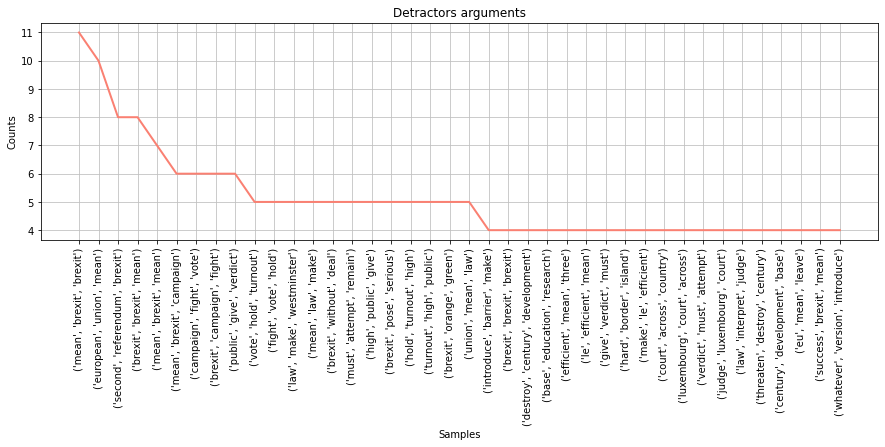

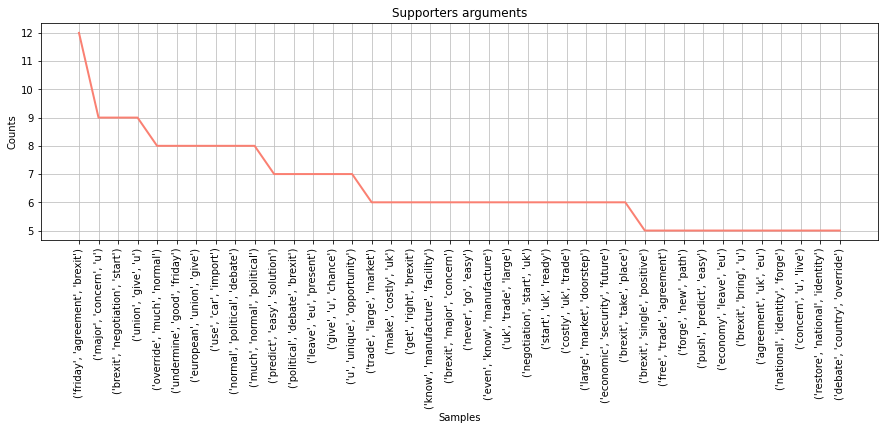

<AxesSubplot:title={'center':'Supporters arguments'}, xlabel='Samples', ylabel='Counts'>

In [49]:
# Compare supporters and detractors dictionaries and getting different keys. 
words_2_detractors_different_keys, words_2_supporters_different_keys, words_2_same_keys = dict_compare(words_2_detractors, words_2_supporters)
words_3_detractors_different_keys, words_3_supporters_different_keys, words_3_same_keys = dict_compare(words_3_detractors, words_3_supporters)

#Filter previous dictionaries to generate a new dictionary that contains the previous keys identified. Source: stack overflow
words_3_detractors_differences = { words_3_detractors_different_keys: words_3_detractors[words_3_detractors_different_keys] for words_3_detractors_different_keys in words_3_detractors_different_keys }
words_3_detractors_differences = nltk.FreqDist(words_3_detractors_differences)
words_3_supporters_differences = { words_3_supporters_different_keys: words_3_supporters[words_3_supporters_different_keys] for words_3_supporters_different_keys in words_3_supporters_different_keys }
words_3_supporters_differences = nltk.FreqDist(words_3_supporters_differences)

#Plot
plt.figure(figsize=(15,4))
words_3_detractors_differences.plot(40, color='salmon', title='Detractors arguments')
plt.figure(figsize=(15,4))
words_3_supporters_differences.plot(40, color='salmon', title='Supporters arguments')

---
After analyzing the different trigrams, we can highlight some of the quotes that sum up the thoughts of each group: 

The detractors think that "brexit threatens to destroy" things as we know them, showing their concern about the problem. 
Also, they state that getting out of the EU would leave UK as an "island with hard border" problems. 
Finally, one of their main concerns is the occurence of a "brexit without a deal" that would harm the long-term interests of the UK. 

On the other side, suporters state that brexit is a "great moment in history" that will give UK an "economic security for the future". For them, this movement is a "large market doorstep" that would allow them to "forge a new path". 

So in the end, we can state we managed to get a good idea of the arguments supporters and detractors use to defend their beliefs related to the Brexit event. 

---

#### Q3: Who were the main supporters of each of the categories? Analyze them according to age, gender, occupation, ...


#### Q4: How did the opinion towards Brexit change during the 5 year span? Did the arguments of each group also change?

## 3.5. Modeling


## 3.6. Interpreting our data

## 3.7. Storytelling and communication

### Plan for storytelling and communication

In [50]:
# Various choices of communication that we thought about but discarded


In [51]:
# Final good choice for communication. Has to be reasonable and sound.


---

# 4. Conclusions

### 4.1. Summary of the notebook


### 4.2. Results obtained


### 4.3. Problems encountered

---

# 5. Future lines